# Classification Models for Healthcare Frauds
## Light GBM 

### SeungHeon Han

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import copy
from collections import Counter
from numpy import where
import statsmodels.api as sm
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import random
import itertools
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn.pipeline import Pipeline
import os              # for directory and file manipulation
import numpy as np     # for basic array manipulation
import pandas as pd    # for dataframe manipulation
import datetime        # for timestamp
from sklearn.metrics import accuracy_score, f1_score, log_loss, mean_squared_error, roc_auc_score, roc_curve


# global constants 
ROUND = 3              # generally, insane precision is not needed 

# set global random seed for better reproducibility
SEED = 1234
seed = 1234
np.random.seed(SEED)
NTHREAD = 4

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# import the cleaned dataset 
#%cd /Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset/partB
partB = pd.read_csv("processed_partB.csv")

In [ ]:
partB = partB.drop("Avg_Mdcr_Stdzd_Amt", axis=1)
partB.head()

,NPI,Type,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Fraud
0,1679548440,Dermatology,O,25,46.0,46,281.000000,128.275435,100.793043,0
1,1184730848,Podiatry,O,15,19.0,19,18.962105,18.571579,13.215263,0
2,1700097557,Diagnostic Radiology,F,32,32.0,32,27.000000,9.387187,7.243750,0
3,1659528339,Mass Immunizer Roster Biller,O,112,114.0,114,4.940614,4.366404,4.366404,0
4,1982966685,Family Practice,O,112,114.0,114,35.000000,25.290000,25.290000,0


### Ratio of Fraud and Non-fraud classes 

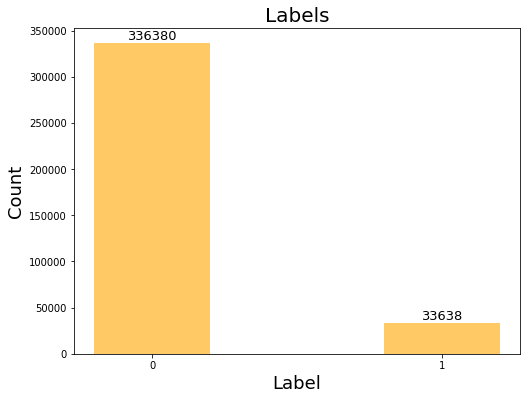

In [ ]:
fig = plt.figure(figsize=(8, 6))

# Plot the bar graph
Y_fraud = list(partB["Fraud"].value_counts())
X_fraud = ["0", "1"]

plot = plt.bar(X_fraud, Y_fraud, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Labels", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
 
# Display the graph on the screen
plt.show()

In [ ]:
ratio = partB["Fraud"].value_counts(normalize = True) 
print("Non-Fraud: ", round(ratio[0]*100, 2), "%")
print("Fraud: ", round(ratio[1]*100, 2), "%")

Non-Fraud:  90.91 %
Fraud:  9.09 %


### Data Spliting

In [4]:
# Assign X and y features

X_var = list(partB.columns)

for var in ["NPI","Fraud"]:
    X_var.remove(var)
cat_feat = "Type"
y_var = "Fraud"

In [5]:
# Split the whole dataset into train and test dataset
# Using a stratified random sampling so that the Fraud-class (1) data are evenly split into train & test sets
x_train, x_test, y_train, y_test = train_test_split(partB[X_var], 
                                                    partB[y_var], 
                                                    test_size=0.1, 
                                                    stratify=partB["Fraud"],
                                                    random_state=SEED)

# Also concatenate the split x & y dataframes 
tr_df = pd.concat([x_train, y_train], axis = 1)
te_df = pd.concat([x_test, y_test], axis = 1)

In [ ]:
# Calculate the odds ratio of Fraud & Non-fraud labels for train & test sets

train_0 = len(tr_df[tr_df["Fraud"] == 0])
train_1 = len(tr_df[tr_df["Fraud"] == 1])

test_0 = len(te_df[te_df["Fraud"] == 0])
test_1 = len(te_df[te_df["Fraud"] == 1])

split_df = pd.DataFrame({"x_axis":["Train", "Test"], 
                         "Ratio":[train_1/train_0, test_1/test_0]})

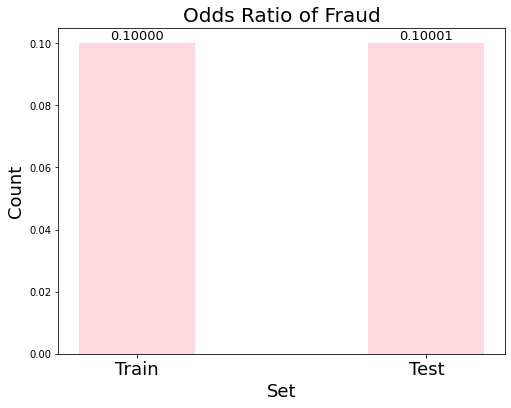

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

# Plot the bar graph
plot = plt.bar(split_df["x_axis"], split_df["Ratio"],
               width = 0.4,
              color = "pink",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%.5f' % height, ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Odds Ratio of Fraud", fontsize = 20)
plt.xlabel("Set", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

ax.set_xticklabels(split_df["x_axis"], fontsize=18)

# Display the graph on the screen
plt.show()

### -----------------SMOTE---------------------

In [ ]:
tr_df.head()

,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Type_Advanced Heart Failure and Transplant Cardiology,Type_All Other Suppliers,Type_Allergy/ Immunology,Type_Allergy/Immunology,...,Type_Thoracic Surgery,Type_Undefined Physician type,Type_Undersea and Hyperbaric Medicine,Type_Unknown Physician Specialty Code,Type_Unknown Supplier/Provider,Type_Unknown Supplier/Provider Specialty,Type_Urology,Type_Vascular Surgery,Place_Of_Srvc,Fraud
348797,12,12.0,12,66.000000,30.146667,24.017500,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
33489,32,51.0,51,140.000000,53.551373,38.991765,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
70149,22,69.0,69,100.000000,69.400725,53.272464,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
151709,40,50.0,50,30.000000,15.430000,15.430000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
84786,61,62.0,62,213.629032,120.259032,65.797581,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Scatter Plot of The Imbalanced Data

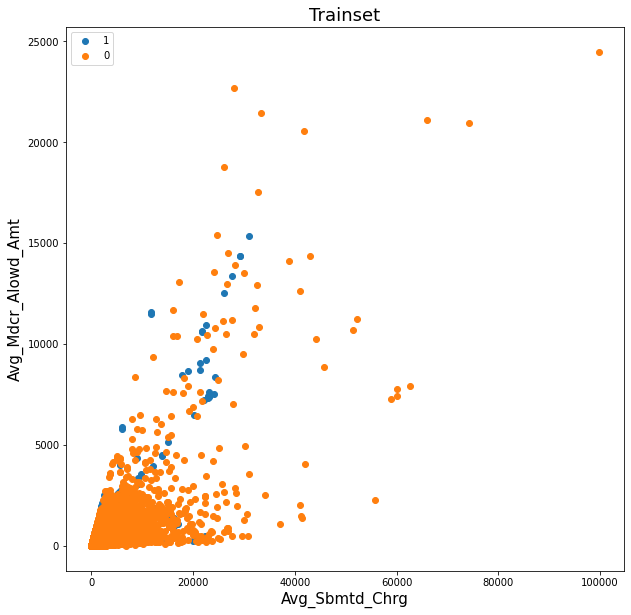

In [ ]:
# scatter plot of the imbalanced data
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(10, 10))

counter = Counter(tr_df[y_var])
for label, _ in counter.items():
    row_ix = where(tr_df[y_var] == label)[0]
    plt.scatter(tr_df[X_var].iloc[row_ix, 3], 
                tr_df[X_var].iloc[row_ix, 4], 
                label=str(label))

plt.title("Trainset", fontsize = 18)
plt.xlabel("Avg_Sbmtd_Chrg", fontsize = 15)
plt.ylabel("Avg_Mdcr_Alowd_Amt", fontsize = 15)
plt.legend()
plt.show()

### Over-Sampling the random_undersampled imbalnaced data through SMOTE

In [6]:
# to SMOTE, temporarily convert categorical variable ('Type') to numerical values
dic = dict(zip(tr_df["Type"].unique().tolist(), np.arange(len(tr_df["Type"].unique())).tolist()))
tr_df['Type'] = tr_df['Type'].map(dic)

tr_df['Type'] = tr_df['Type'].astype('uint8')

tr_df = pd.get_dummies(tr_df, drop_first = True)
tr_df = tr_df.rename(columns = {"Place_Of_Srvc_O":"Place_Of_Srvc"})

In [7]:
# SMOTE
from imblearn.over_sampling import SMOTE
oversample = over_sampling.SMOTE(sampling_strategy = 0.5, random_state = SEED)
tr_X, tr_y = oversample.fit_resample(tr_df[X_var], tr_df[y_var])

In [8]:
# Convert the numerical values of the categorical variable back to the categorical values
inv_dic = dict([(val, key) for key, val in dic.items()])
tr_X['Type'] = tr_X['Type'].map(inv_dic)
tr_X.head()

,Type,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt
0,Optometry,1,12,12.0,12,66.000000,30.146667,24.017500,24.764167
1,Orthopedic Surgery,1,32,51.0,51,140.000000,53.551373,38.991765,45.058627
2,Podiatry,1,22,69.0,69,100.000000,69.400725,53.272464,58.410870
3,Family Practice,1,40,50.0,50,30.000000,15.430000,15.430000,15.440000
4,Diagnostic Radiology,1,61,62.0,62,213.629032,120.259032,65.797581,77.650806


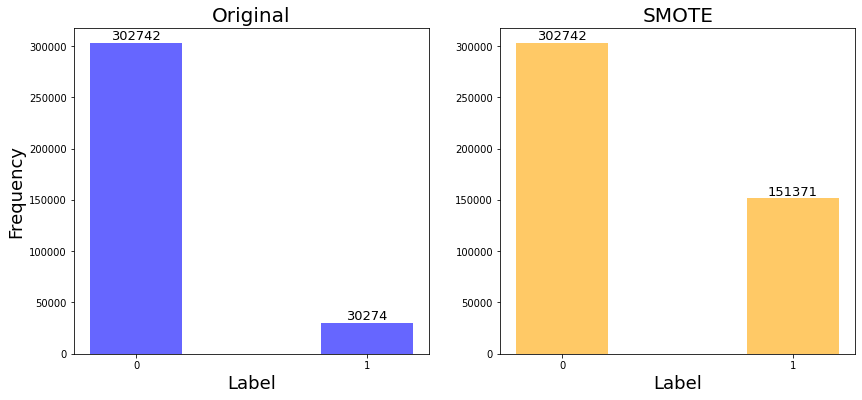

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(121)

# Plot the bar graph for the original train
Y_fraud = list(y_train.value_counts())
Labels = ["0", "1"]

plot = plt.bar(Labels, Y_fraud, 
               width = 0.4,
              color = "blue",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("Original", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18)


plt.subplot(122)

# Plot the bar graph for the over-sampled train
Y_fraud_smote = list(tr_y.value_counts())

plot_smote = plt.bar(Labels, Y_fraud_smote, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot_smote:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("SMOTE", fontsize = 20)
plt.xlabel("Label", fontsize = 18)

# Display the graph on the screen
plt.show()

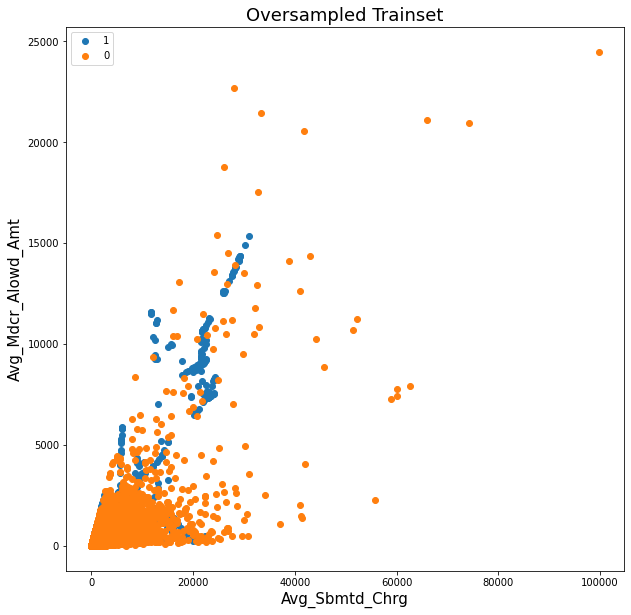

In [ ]:
# scatter plot of the data transformed by SMOTE 
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(10, 10))

counter = Counter(tr_y)
for label, _ in counter.items():
    row_ix = where(tr_y == label)[0]
    plt.scatter(tr_X.iloc[row_ix, 3], tr_X.iloc[row_ix, 4], label=str(label))

plt.title("Oversampled Trainset", fontsize = 18)
plt.xlabel("Avg_Sbmtd_Chrg", fontsize = 15)
plt.ylabel("Avg_Mdcr_Alowd_Amt", fontsize = 15)
plt.legend()
plt.show()

## Model Training 

### Data Partitioning (Train & Valid)

In [9]:
# Split train and validation sets 
trans_tr_df = pd.concat([tr_X, tr_y], axis = 1)
np.random.seed(SEED)

ratio = 0.8 # split train & validation sets with 7:3 ratio 

split = np.random.rand(len(trans_tr_df)) < ratio # define indices of 70% corresponding to the training set

train = trans_tr_df[split]
valid = trans_tr_df[~split]

train["Type"] = train["Type"].astype("category")
valid["Type"] = valid["Type"].astype("category")

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 363675, columns = 10
Validation data rows = 90438, columns = 10


## LightGBM

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import time

tic = time.time()

params = {'num_iterations':[3000], 
          'learning_rate':[0.005,0.01, 0.1], 
          'max_depth':[0, 5, 11],
          'num_leaves':[20,31,100],
          'early_stopping_rounds':[30],
          'random_seed':[SEED]}

model = RandomizedSearchCV(LGBMClassifier(), params, cv=5, n_iter=3)
model.fit(train[X_var], train[y_var], 
          eval_set=[(valid[X_var], valid[y_var]), 
                    (train[X_var], train[y_var])],
          eval_metric='logloss')

toc = time.time() - tic
print(np.round(toc, 4))

In [28]:
 model.best_params_

{'early_stopping_rounds': 30,
 'learning_rate': 0.1,
 'max_depth': 11,
 'num_iterations': 3000,
 'num_leaves': 100,
 'random_seed': 1234}

In [37]:
te_df["Type"] = te_df["Type"].astype("category")
te_df['Place_Of_Srvc'] = pd.get_dummies(te_df['Place_Of_Srvc'], drop_first=True)

In [38]:
def max_f1(testset, res):
    pred_prob = model.predict_proba(testset[X_var])
    phat_df = pd.DataFrame([phat[1] for phat in pred_prob], columns = ["phat"])
    temp_df = pd.concat([testset[[y_var]].reset_index(drop=True), phat_df],axis=1)
    
    f1_df = pd.DataFrame(columns = ["cut", "f1_score"])
    
    for cut in np.arange(0, 1+res, res):
        temp_df["pred"] = np.where(temp_df["phat"] > cut, 1, 0)
        f1 = f1_score(temp_df["Fraud"], temp_df["pred"])
        f1_df = f1_df.append({"cut":cut, 
                              "f1_score":f1}, 
                             ignore_index=True)
        
    max_f1 = f1_df.loc[f1_df["f1_score"] == f1_df["f1_score"].max()]
    return max_f1

max_f1 = max_f1(te_df, 0.01)
max_f1

,cut,f1_score
35,0.35,0.422962


In [92]:
tic = time.time()

best_params = {'early_stopping_rounds': 100,
 'learning_rate': 0.1,
 'max_depth': 18,
 'num_iterations': 5000,
 'num_leaves': 150,
 'random_seed': 1234}
best_model = LGBMClassifier(**best_params)
best_model.fit(train[X_var], train[y_var], 
          eval_set=[(valid[X_var], valid[y_var]), 
                    (train[X_var], train[y_var])],
          eval_metric='auc')

toc = time.time() - tic
print(np.round(toc, 4))

[1]	valid_0's auc: 0.78506	valid_0's binary_logloss: 0.617288	valid_1's auc: 0.787429	valid_1's binary_logloss: 0.613714
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.795343	valid_0's binary_logloss: 0.598725	valid_1's auc: 0.797187	valid_1's binary_logloss: 0.595126
[3]	valid_0's auc: 0.799072	valid_0's binary_logloss: 0.583658	valid_1's auc: 0.80102	valid_1's binary_logloss: 0.579941
[4]	valid_0's auc: 0.813153	valid_0's binary_logloss: 0.568482	valid_1's auc: 0.815728	valid_1's binary_logloss: 0.564658
[5]	valid_0's auc: 0.816821	valid_0's binary_logloss: 0.557607	valid_1's auc: 0.819602	valid_1's binary_logloss: 0.553691
[6]	valid_0's auc: 0.82274	valid_0's binary_logloss: 0.546065	valid_1's auc: 0.826019	valid_1's binary_logloss: 0.54205
[7]	valid_0's auc: 0.823312	valid_0's binary_logloss: 0.537728	valid_1's auc: 0.826528	valid_1's binary_logloss: 0.533603
[8]	valid_0's auc: 0.823889	valid_0's binary_logloss: 0.530373	valid_1's auc: 0.827447	

In [93]:
def best_f1(testset, res):
    pred_prob = best_model.predict_proba(testset[X_var])
    phat_df = pd.DataFrame([phat[1] for phat in pred_prob], columns = ["phat"])
    temp_df = pd.concat([testset[[y_var]].reset_index(drop=True), phat_df],axis=1)
    
    f1_df = pd.DataFrame(columns = ["cut", "f1_score"])
    
    for cut in np.arange(0, 1+res, res):
        temp_df["pred"] = np.where(temp_df["phat"] > cut, 1, 0)
        f1 = f1_score(temp_df["Fraud"], temp_df["pred"])
        f1_df = f1_df.append({"cut":cut, 
                              "f1_score":f1}, 
                             ignore_index=True)
        
    max_f1 = f1_df.loc[f1_df["f1_score"] == f1_df["f1_score"].max()]
    return max_f1

best_f1 = best_f1(te_df, 0.01)
best_f1

,cut,f1_score
29,0.29,0.430952


In [94]:
from sklearn.metrics import roc_auc_score

pred_prob = best_model.predict_proba(te_df[X_var])
pred_df = pd.DataFrame([phat[1] for phat in pred_prob], columns = ["pred"])
pred_df = pd.concat([te_df[[y_var]].reset_index(drop=True), pred_df], axis=1)

pred_df["pred"] = np.where(pred_df["pred"] > 0.29, 1, 0)

In [95]:
roc_auc_score(pred_df["Fraud"],pred_df["pred"])

0.7076521838906072